In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim


from bokeh.plotting import figure
from bokeh.io import output_notebook, show

from PIL import Image, ImageDraw

In [2]:
output_notebook()

Loading BokehJS ...

# Generator
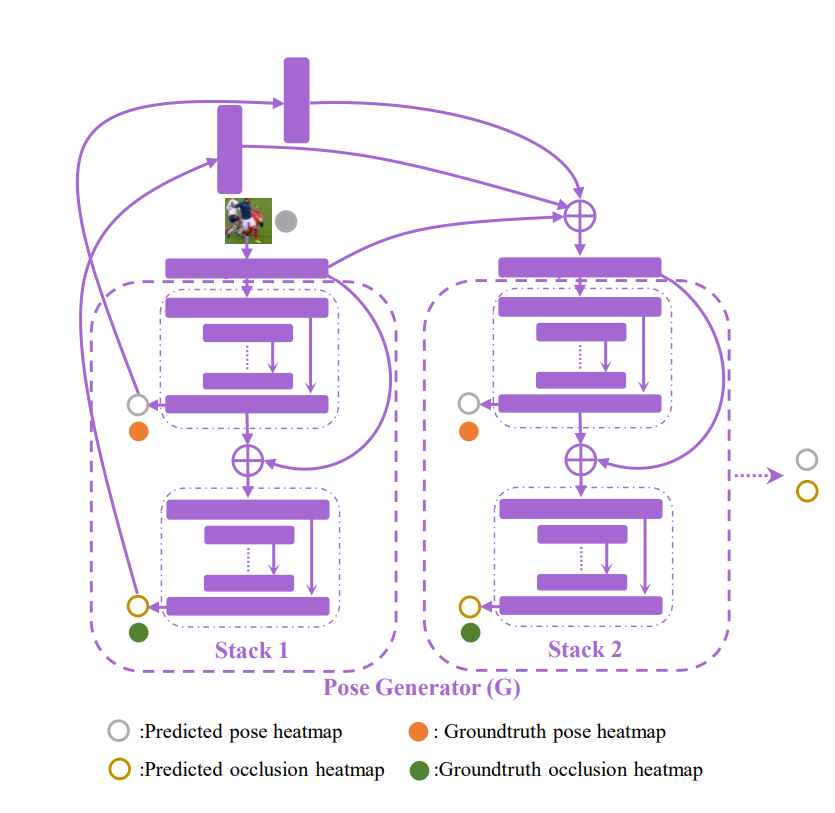

In [37]:
class Generator:
    def __init__(self, batch_size, image_shape, stack_size=2, module_size=2, channel_size=[32, 64, 128]):
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.stack_size = stack_size
        self.module_size = module_size
        self.channel_size = channel_size
        self.alpha = 0.2
        #with tf.variable_scope("generator"):
        self.inputs = tf.placeholder(tf.float32, shape=[None, *image_shape], name="inputs")
    
    def leaky_relu(self, inputs):
        return tf.maximum(inputs, inputs * self.alpha)
    
    def kinit(size, dtype, partition_info):
        return tf.random_normal(size, stddev=0.02)

    def build_module(self, inputs, name, channels=[32, 64, 128]):
        with tf.variable_scope(name + "_module"):
            with slim.arg_scope([slim.conv2d, slim.conv2d_transpose], padding="SAME", kernel_size=3, stride=2, activation_fn=self.leaky_relu, 
                          weights_initializer=tf.truncated_normal_initializer(stddev=0.01)):
                return self.conv_module(inputs, channels)

    def conv_module(self, inputs, channels):
        conv_layer = slim.conv2d(inputs, channels[0])
        if len(channels) > 1:
            #recursive
            inner_layer = self.conv_module(conv_layer, channels[1:])
            concat_layer = tf.concat([conv_layer, inner_layer], axis=-1)
        else:
            concat_layer = conv_layer
        deconv_layer = slim.conv2d_transpose(concat_layer, channels[0])
        return deconv_layer
    
    def build_stack(self, inputs, training=True):
        with slim.arg_scope([slim.conv2d], kernel_size=5, stride=1, padding="SAME",
                       activation_fn=self.leaky_relu, weights_initializer=tf.truncated_normal_initializer(stddev=0.02)):
            conv_layer = slim.conv2d(inputs, num_outputs=32, )
            pose_heatmap = self.build_module(conv_layer, "pose", self.channel_size)
            concat_layer = tf.concat([pose_heatmap, conv_layer], axis=-1)
            occlusion_heatmap = self.build_module(concat_layer, "occlusion", self.channel_size)
            pose_heatmap = slim.conv2d(pose_heatmap, 1)
            occlusion_heatmap = slim.conv2d(occlusion_heatmap, 1)
            output = tf.concat([conv_layer, pose_heatmap, occlusion_heatmap], axis=-1, name="stack_output")
            return output, pose_heatmap, occlusion_heatmap
    
    def build(self, training=True):
        module_input = self.inputs
        for i in range(self.module_size):
            with tf.variable_scope("generator_"+str(i), reuse=not training):
                module_output, pose_heatmap, occlusion_heatmap = self.build_stack(module_input, training)
                module_input = module_output
        self.pose_heatmap = pose_heatmap
        self.occlusion_heatmap = occlusion_heatmap

In [28]:
def resize_img(fileName, new_size=[512, 512]):
    filePattern = "../keypoint_train_images_20170902/{}.jpg"
    fileSource = filePattern.format(fileName)
    avatar = Image.open(fileSource)
    return avatar.resize(new_size, Image.ANTIALIAS)

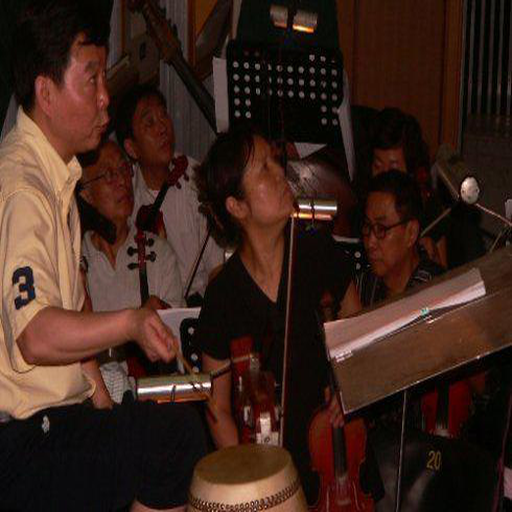

In [29]:
resize_img("38a5c50fa46133921238e74da08f2dd072e5c7e3")

In [44]:
class Discriminator:
    def __init__(self, batch_size, image_shape, output_size=14, channel_size=[32, 64, 128]):
        self.batch_size = batch_size
        self.image_size = image_size
        self.channel_size = channel_size
        self.output_size = output_size
        self.alpha = 0.2

    def leaky_relu(self, inputs):
        return tf.maximum(inputs, inputs * self.alpha)
    
    def kinit(size, dtype, partition_info):
        return tf.random_normal(size, stddev=0.02)
    
    def build_module(self, inputs, name, channels=[32, 64, 128]):
        with tf.variable_scope(name + "_module"):
            with slim.arg_scope([slim.conv2d, slim.conv2d_transpose], padding="SAME", kernel_size=3, stride=2, activation_fn=self.leaky_relu, 
                          weights_initializer=tf.truncated_normal_initializer(stddev=0.01)):
                return self.conv_module(inputs, channels)

    def conv_module(self, inputs, channels):
        conv_layer = slim.conv2d(inputs, channels[0])
        if len(channels) > 1:
            #recursive
            inner_layer = self.conv_module(conv_layer, channels[1:])
            concat_layer = tf.concat([conv_layer, inner_layer], axis=-1)
        else:
            concat_layer = conv_layer
        deconv_layer = slim.conv2d_transpose(concat_layer, channels[0])
        return deconv_layer
    
    def build(self, inputs, name, reuse=False):
        with tf.variable_scope("discriminator_"+name, reuse=reuse):
            conv_output = self.build_module(inputs, name, self.channel_size)
            flatten_layer = slim.flatten(conv_output)
            self.digits = tf.layers.dense(flatten_layer, self.output_size, 
                                          kernel_initializer=tf.random_normal_initializer(stddev=0.02))
            self.outputs = tf.nn.sigmoid(self.digits)

In [40]:
batch_size= 64
image_size = [512, 512, 3]

In [50]:
tf.reset_default_graph()

#build generator model
generator = Generator(batch_size, image_size)
generator.build(True)
#get generator output
pose_heatmap = generator.pose_heatmap
occlusion_heatmap = generator.occlusion_heatmap

#create discriminator
pose_discriminator = Discriminator(batch_size, image_size)
conf_discriminator = Discriminator(batch_size, image_size)

#true heatmap input
pose_pl = tf.placeholder(tf.float32, [None, image_size[0], image_size[1], 1], name="pose_true_heatmap")
occlusion_pl = tf.placeholder(tf.float32, [None, image_size[0], image_size[1], 1], name="occlusion_true_heatmap")

#discriminator for true heatmap
pose_true_inputs = tf.concat([generator.inputs, pose_pl, occlusion_pl], axis=-1,
                            name="pose_true_inputs")
conf_true_inputs = tf.concat([pose_pl, occlusion_pl], axis=-1,
                            name="conf_true_inputs")
pose_discriminator.build(pose_true_inputs, "pose")
conf_discriminator.build(conf_true_inputs, "confidence")
pose_true_output = [pose_discriminator.digits, pose_discriminator.outputs]
conf_true_output = [conf_discriminator.digits, conf_discriminator.outputs]

#discriminator for fake heatmap
pose_fake_inputs = tf.concat([generator.inputs, generator.pose_heatmap, generator.occlusion_heatmap], axis=-1,
                            name="pose_fake_inputs")
conf_fake_inputs = tf.concat([generator.pose_heatmap, generator.occlusion_heatmap], axis=-1,
                            name="conf_fake_inputs")
pose_discriminator.build(pose_fake_inputs, "pose", True)
conf_discriminator.build(conf_fake_inputs, "confidence", True)
pose_fake_output = [pose_discriminator.digits, pose_discriminator.outputs]
conf_fake_output = [conf_discriminator.digits, conf_discriminator.outputs]

variables = tf.trainable_variables()
slim.summarize_tensors(variables)
merged = tf.summary.merge_all()


In [ ]:
with tf.Session() as sess:
    tf.summary.FileWriter("summary", sess.graph)
    sess.run(tf.global_variables_initializer())
    sess.run(merged)